### GİRİŞ

Bu Projemizde Bir telekom şirketine ait verilerden müşterilerin ayrılıp ayrılmayacaklarını tahmin etmeye çalışacağız. İlgili kütüphanelerin ve veri kümemizin yüklenmesi ile başlıyoruz.

### VERİ KEŞFİ

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [96]:
df = pd.read_excel('Churn.xls', index_col=None)
df.to_csv('churn.csv')

In [97]:
df.head()

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Int'l Plan,VMail Plan,...,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Area Code,Phone
0,128,25,265.100,197.400,244.700,10.000,1,0,0,1,...,45.070,99,16.780,91,11.010,3,2.700,KS,415,382-4657
1,107,26,161.600,195.500,254.400,13.700,1,0,0,1,...,27.470,103,16.620,103,11.450,3,3.700,OH,415,371-7191
2,137,0,243.400,121.200,162.600,12.200,0,0,0,0,...,41.380,110,10.300,104,7.320,5,3.290,NJ,415,358-1921
3,84,0,299.400,61.900,196.900,6.600,2,0,1,0,...,50.900,88,5.260,89,8.860,7,1.780,OH,408,375-9999
4,75,0,166.700,148.300,186.900,10.100,3,0,1,0,...,28.340,122,12.610,121,8.410,3,2.730,OK,415,330-6626


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
Account Length    3333 non-null int64
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Eve Mins          3333 non-null float64
Night Mins        3333 non-null float64
Intl Mins         3333 non-null float64
CustServ Calls    3333 non-null int64
Churn             3333 non-null int64
Int'l Plan        3333 non-null int64
VMail Plan        3333 non-null int64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
State             3333 non-null object
Area Code         3333 non-null int64
Phone             3333 non-null object
dtypes: float64(8), int64(11), object(2)
memory usage: 546.9+ KB


In [99]:
for i in df.columns:
    print(i,"tekil değer sayısı=", df[i].nunique())

Account Length tekil değer sayısı= 212
VMail Message tekil değer sayısı= 46
Day Mins tekil değer sayısı= 1667
Eve Mins tekil değer sayısı= 1611
Night Mins tekil değer sayısı= 1591
Intl Mins tekil değer sayısı= 162
CustServ Calls tekil değer sayısı= 10
Churn tekil değer sayısı= 2
Int'l Plan tekil değer sayısı= 2
VMail Plan tekil değer sayısı= 2
Day Calls tekil değer sayısı= 119
Day Charge tekil değer sayısı= 1667
Eve Calls tekil değer sayısı= 123
Eve Charge tekil değer sayısı= 1440
Night Calls tekil değer sayısı= 120
Night Charge tekil değer sayısı= 933
Intl Calls tekil değer sayısı= 21
Intl Charge tekil değer sayısı= 162
State tekil değer sayısı= 51
Area Code tekil değer sayısı= 3
Phone tekil değer sayısı= 3333


In [100]:
df["Area Code"].value_counts()

415    1655
510     840
408     838
Name: Area Code, dtype: int64

Üstte her bir değişkenimizin tekil değer sayısına baktık. 2 tekil değeri olan değişkenlerimiz aslında kategorik değişkenler. Aldıkları değer 0 ve 1 ile ifade edildklerinden türleri  tamsayı görünüyor. Bunlar **Churn,Intl Plan,VMail Plan** değişkenleri **Area Code** ise 3 farklı değer içeriyor her bir kod bir yeri belirttiğinden  kullanacaksak onu da kategorik olarak düşünmeliyiz. Diğer bir konu da **Phone** ve **State** telefon numaraları gözlem sayısı kadar olduğundan bize ekstra bilgi vermez. Eyalet bilgisi de tüm eyaletleri kapsıyor ve **Area Code**  ile ikisi için de hedef ile alakalı bir ilişki düşünemediğimden bu üçünü kullanmadan, silerek devam edeceğiz.

In [101]:
del_columns=["State","Phone","Area Code"] 
df=df.drop(del_columns,axis=1)

Değişkenlerin ikili olarak ilişkilerini anlamaya çalışalım. Aşağıda korelasyon matrisi sürekli değişkenlerin aralarındaki ilişkiyi gösteriyor.

In [102]:
#df["Churn"]=df["Churn"].replace({1:'pos',0:'neg'})
df["Int'l Plan"]=df["Int'l Plan"].replace({1:'pos',0:'neg'})
df["VMail Plan"]=df["VMail Plan"].replace({1:'pos',0:'neg'})

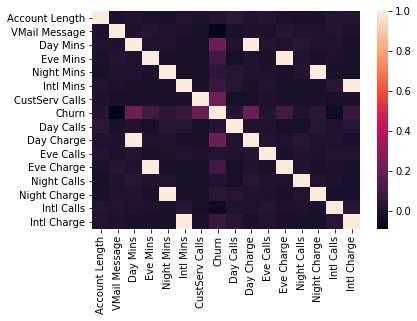

In [103]:
sns.heatmap(df.corr())


Kategorik olan hedef değişkenimizin de tabloya şu an için dahil olduğunu unutmayalım. Tabloda birebir aynı sayılacak ilişkide değişken çifteleri var bunları not alıp modelimize aynı anda dahil olmalarını engellemeliyiz.Bu çiftler:  
* VMail Message-VMail Plan 
* Day Mins-Day Charge
* Eve Mins-Eve Charge
* Night Mins-Night Charge
* Intl Mins-Intl Charge  
Tabloda kayda değer başka bilgi görülmüyor.Şimdi de hedef değişkenimiz kategorik olduğundan bar grafiklerle sürekli değişkenlerle ilişkilerine bakıp işimize yarayacak olanları anlamaya çalışalım.

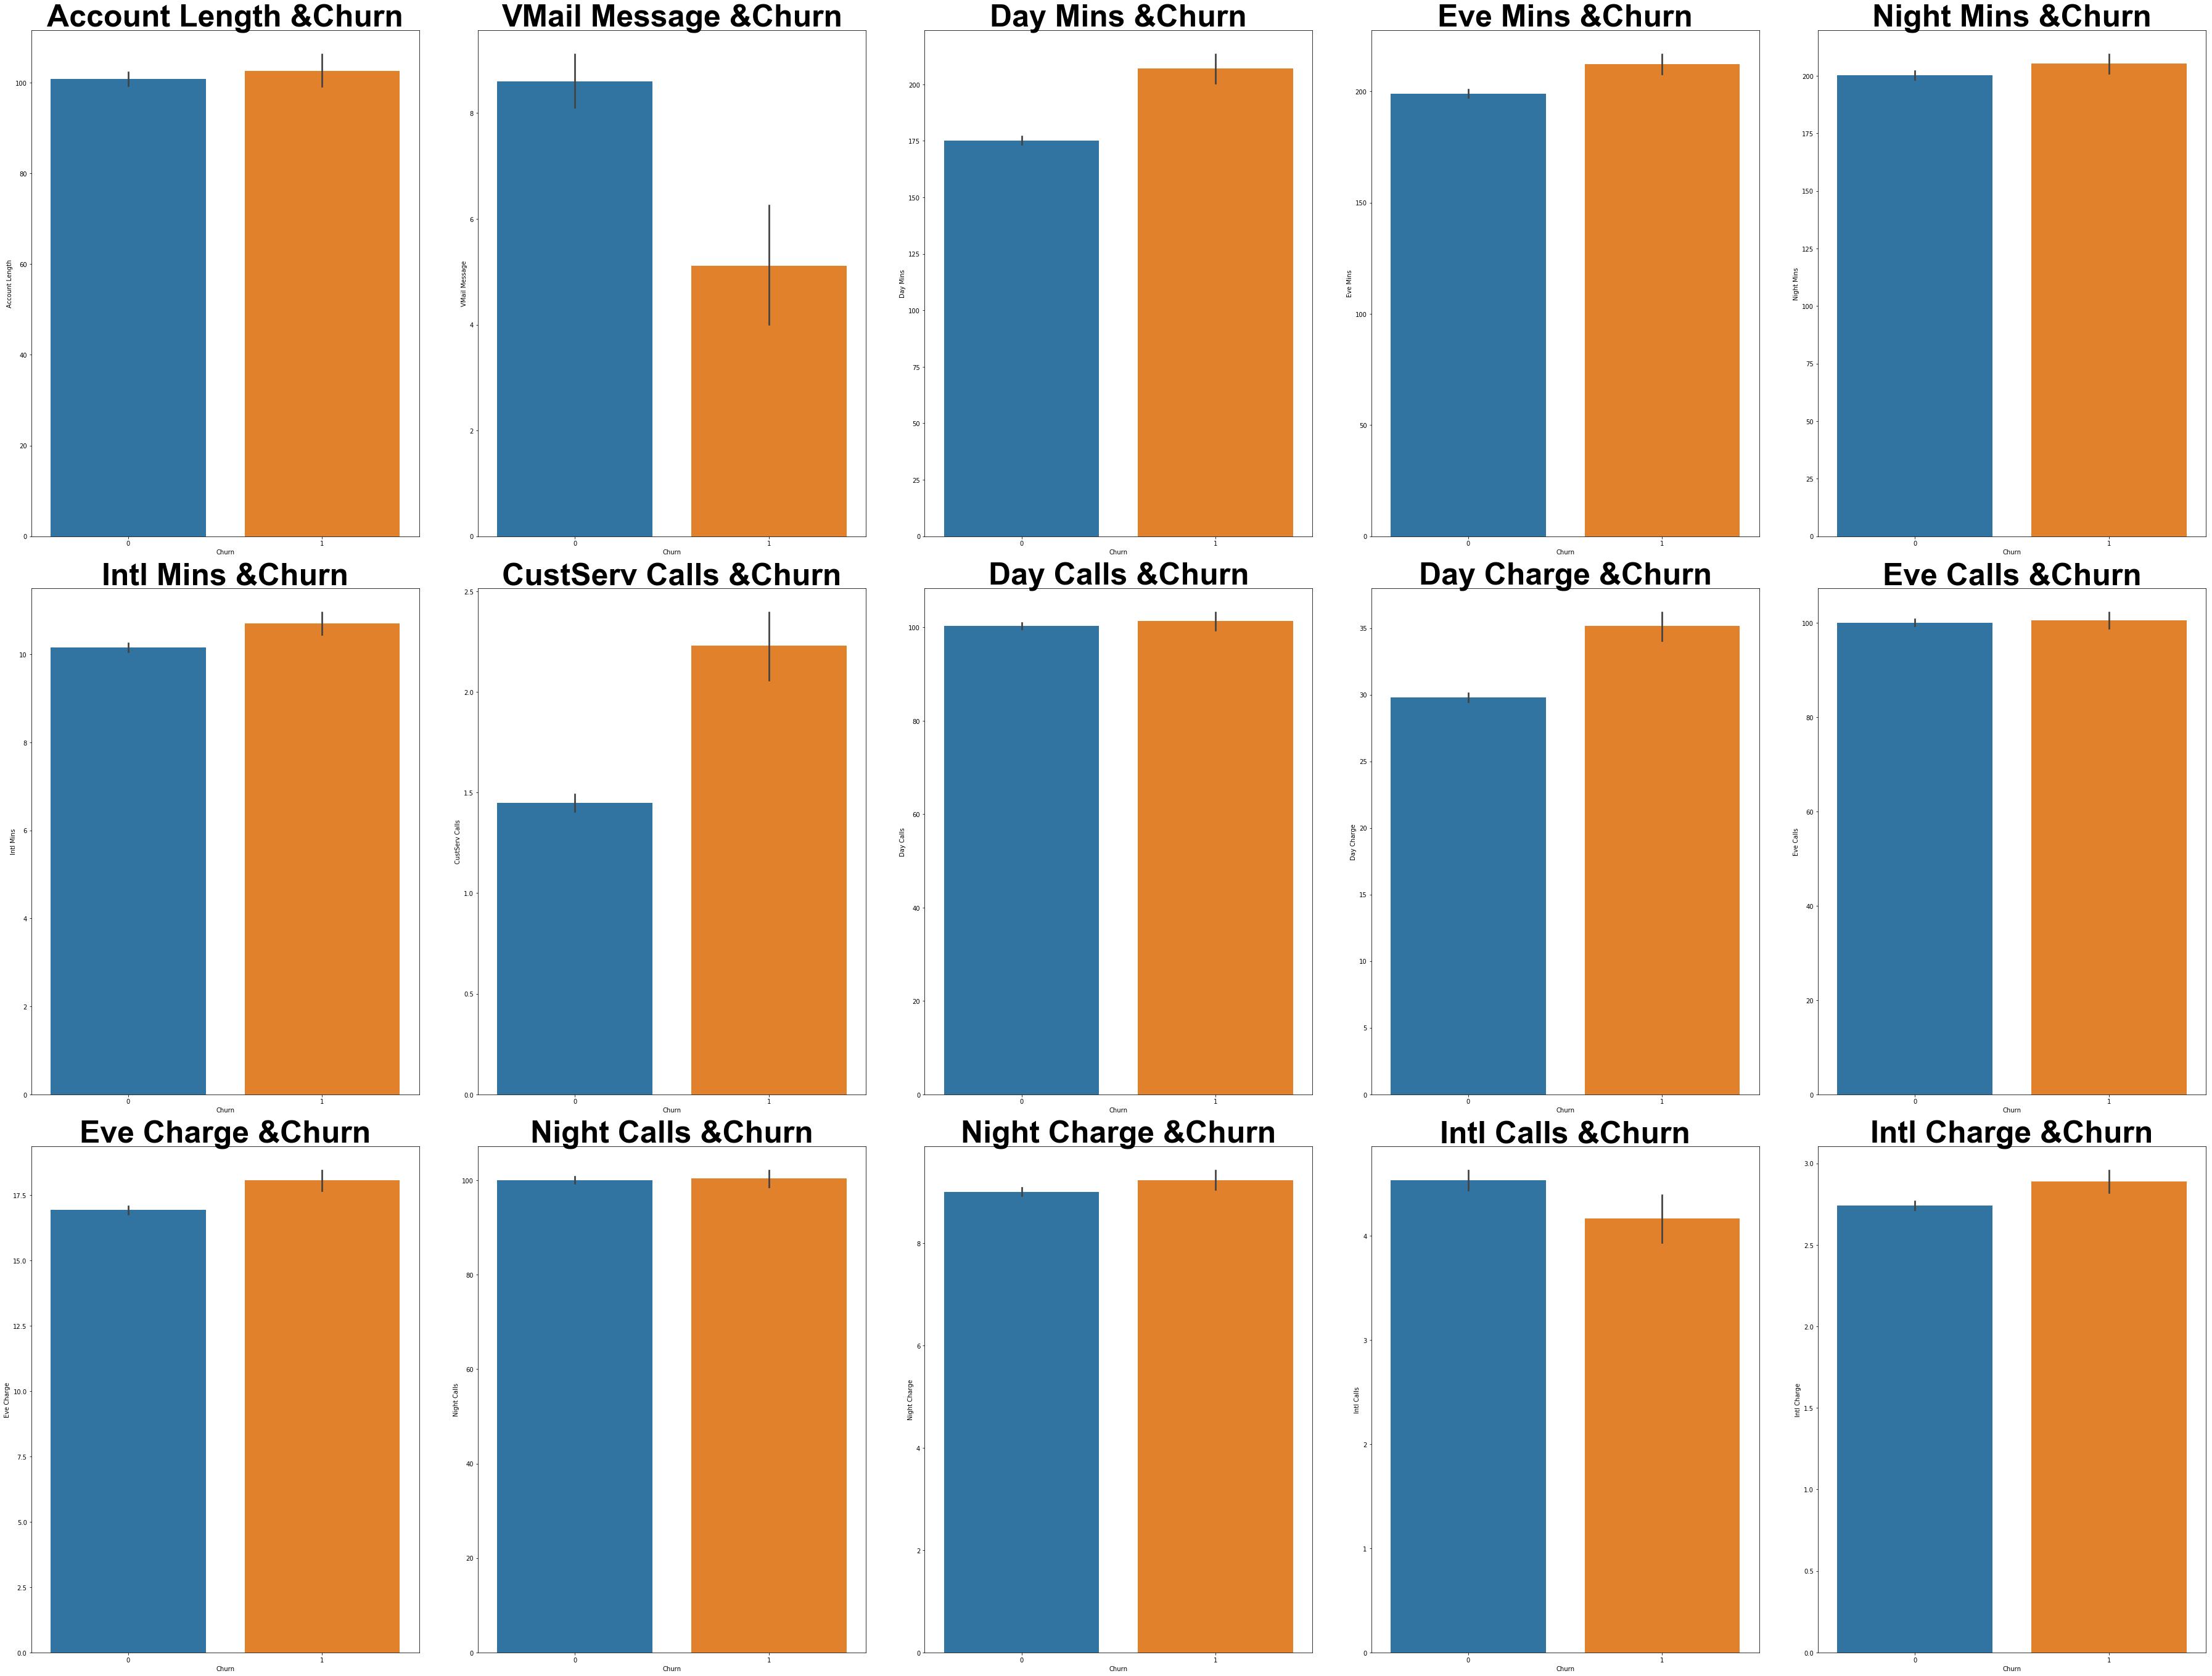

In [105]:
columns=['Account Length', 'VMail Message', 'Day Mins', 'Eve Mins', 'Night Mins',
       'Intl Mins', 'CustServ Calls', 
       'Day Calls', 'Day Charge', 'Eve Calls', 'Eve Charge', 'Night Calls',
       'Night Charge', 'Intl Calls', 'Intl Charge']
title_font = {'family': 'arial', 'color': 'black','weight': 'bold','size': 50 }

plt.figure(figsize=(50,50))
for i,j in zip(columns, range(1,19)):
        plt.subplot(4,5,j)
        sns.barplot(df['Churn'],df[i])
        plt.title(i+' '+'&'+ 'Churn', fontdict = title_font)
plt.tight_layout()
plt.show()

Garfikleri incelediğimizde **Churn** aldığı farklı değerlere göre değişkenlik gösteren değişkenler:**VMail Message,Day Mins,Eve Mins,Intl Mins,CustServ Calls,Day Charge,Eve Charge,Intl Calls,Intl Charge** olarak görünüyor. Şimdi t-testi aracılığıyla bu değişkenlerden hangisinin gösterdiği farklılık istatistiksel olarak anlamlı imiş anlayalım.

In [106]:
val=[]
for i,j in zip(columns, range(1,19)):
        x= df[df['Churn']==0][i]
        y = df[df['Churn']==1][i]
        test=sts.ttest_ind(x,y) 
        if test[1]< 0.05:
            #print(i+" anlamlı bir degisken olabilir.")
            val.append(i)
print("Hedef değişkenin anlaşılmasında anlamlı olabilcek değişkenler:\n",val)    

Hedef değişkenin anlaşılmasında anlamlı olabilcek değişkenler:
 ['VMail Message', 'Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins', 'CustServ Calls', 'Day Charge', 'Eve Charge', 'Night Charge', 'Intl Calls', 'Intl Charge']


t-testi ile  sürekli değişkenlerden hedef için istatistiksel olarak anlamlı olanları yukarda anladık.Şimdi de kategori değişkenler için benzerini yapalım. Çapraz tablo ile değerlere bakalım.Sonra da ki-kare testi ile dğerlerin farklılıklarının anlamlı olup olmadığını öğrenelim.

In [107]:
for i in ["Int'l Plan","VMail Plan"]:
    x= pd.crosstab(df['Churn'],df[i])
    print(x,"\n\ntablosu için ki-kare değerleri:",sts.chisquare(x, axis=None),"\n")

Int'l Plan   neg  pos
Churn                
0           2664  186
1            346  137 

tablosu için ki-kare değerleri: Power_divergenceResult(statistic=5391.844884488449, pvalue=0.0) 

VMail Plan   neg  pos
Churn                
0           2008  842
1            403   80 

tablosu için ki-kare değerleri: Power_divergenceResult(statistic=2559.393639363936, pvalue=0.0) 



Üstteki sonuçlara göre iki değişken için de farklılıklar anlamlı çıktı.Modelimizi inşaa ederken anlamlı çıkan değişkenleri dahil edeceğiz. Kendi içinde korelasyonu yüksek olanlardan çoklu doğrusallık olmaması için birini dahil ederken diğerini dışarda tutacağız.

### MODEL KURULUMU ve YORUMU

In [108]:
X=df[['VMail Plan','Day Mins','Night Mins','Intl Mins','CustServ Calls',"Int'l Plan",'Eve Charge', 'Intl Calls']]
y=df["Churn"]

In [109]:

X = pd.get_dummies(data=X, drop_first=True)
X_eğitim, X_test, y_eğitim, y_test =  train_test_split(X, y, test_size=0.20, random_state=111)

log_reg = LogisticRegression()
log_reg.fit(X_eğitim, y_eğitim)

egitim_dogruluk = log_reg.score(X_eğitim, y_eğitim)
test_dogruluk = log_reg.score(X_test, y_test)
print('Modelin eğitim verisindeki doğruluğu : {:.2f}'.format(egitim_dogruluk), 
      'Modelin test verisindeki doğruluğu   : {:.2f}'.format(test_dogruluk), sep='\n')

Modelin eğitim verisindeki doğruluğu : 0.86
Modelin test verisindeki doğruluğu   : 0.85


In [110]:
#statsmodel ile model inşaası
X=df[['VMail Plan','Day Mins','Night Mins','Intl Mins','CustServ Calls',"Int'l Plan",'Eve Charge', 'Intl Calls']]
y=df["Churn"]

X = pd.get_dummies(data=X, drop_first=True)
X_eğitim_sm, X_test_sm, y_eğitim_sm, y_test_sm =  train_test_split(X, y, test_size=0.20, random_state=111)

X_eğitim_sm=sm.add_constant(X_eğitim_sm)
result=sm.Logit(y_eğitim_sm,X_eğitim_sm).fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.324837
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2657
Method:                           MLE   Df Model:                            8
Date:                Wed, 04 Dec 2019   Pseudo R-squ.:                  0.2183
Time:                        21:05:45   Log-Likelihood:                -866.02
converged:                       True   LL-Null:                       -1107.9
Covariance Type:            nonrobust   LLR p-value:                 2.221e-99
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -7.8214      0.575    -13.606      0.000      -8.948      -6.695
Day Mins         

Modelimizi ilk olarak Sci-kit learn sonra da statsmodel aracılığıyla kurduk.Statsmodel aracılığıyla kurduğumuz modelin özet tabosunu inceleyelim. Kullanılan tüm değişkenler istatistiksel olarak anlamlı görünüyor.Hedefi en çok etkileyen değişkenler sıra ile **Int'l Plan > VMail Plan > CustServ Calls > Intl Calls > Eve Charge > Intl Mins >  Day Mins > Night Mins** şeklinde. Katsayısı Negatif olanlar tabiki hedefimiz ile ters bir ilişkide.


### MODELİN BAŞARISININ DEĞERLENDİRİLMESİ

#### a. Hata Matrisi 

In [111]:
tahmin_eğitim=log_reg.predict(X_eğitim)
tahmin_test=log_reg.predict(X_test)

hata_matrisi_eğitim = confusion_matrix(y_eğitim, tahmin_eğitim)
hata_matrisi_test = confusion_matrix(y_test, tahmin_test)

print("Hata Matrisi (Eğitim verileri)", "-"*30, hata_matrisi_eğitim, sep="\n")
print("Hata Matrisi (Test verileri)", "-"*30, hata_matrisi_test, sep="\n")

Hata Matrisi (Eğitim verileri)
------------------------------
[[2226   51]
 [ 315   74]]
Hata Matrisi (Test verileri)
------------------------------
[[555  18]
 [ 81  13]]


#### b. Farklı Metriklerin Sonuçları

In [112]:
print("Modelden alınan doğruluk değeri : ",  log_reg.score(X_test, y_test))
print("Recall_score() değeri        : ",  recall_score(y_test, tahmin_test))
print("precision_score() değeri        : ",  precision_score(y_test, tahmin_test))
print("accuracy_score() değeri         : ",  accuracy_score(y_test, tahmin_test))
print("f1_score() değeri     : ",  f1_score(y_test, tahmin_test))
print('\n')
print(classification_report(y_test,tahmin_test) )
print('\n')


Modelden alınan doğruluk değeri :  0.8515742128935532
Recall_score() değeri        :  0.13829787234042554
precision_score() değeri        :  0.41935483870967744
accuracy_score() değeri         :  0.8515742128935532
f1_score() değeri     :  0.20800000000000002


              precision    recall  f1-score   support

           0       0.87      0.97      0.92       573
           1       0.42      0.14      0.21        94

    accuracy                           0.85       667
   macro avg       0.65      0.55      0.56       667
weighted avg       0.81      0.85      0.82       667





#### c. ROC Curve, AUC ve Logaritmik Kayıp

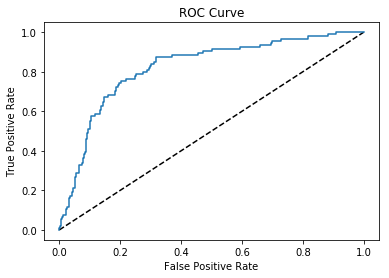

AUC Değeri :  0.820986966692659
Logartimik Kayıp (log-loss) :  0.33004516877382417
Hata Oranı                  :  0.14842578710644683


In [113]:
tahmin_test_ihtimal = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds  = roc_curve(y_test, tahmin_test_ihtimal)

#ROC Eğrisini çizdiriyoruz.
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('AUC Değeri : ', roc_auc_score(y_test, tahmin_test_ihtimal))
print("Logartimik Kayıp (log-loss) : " , log_loss(y_test, tahmin_test_ihtimal))
print("Hata Oranı                  : " , 1- accuracy_score(y_test, tahmin_test))

### VERİ KÜMESİNİN DENGELENMESİ

In [114]:
df['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

Hedef değişkenimizin aldığı değerlerin sayısına bakınca dengesiz olduğu görülüyor. Bu bölümde çeşitli dengeleme yöntemlerini kullanıp modelimiz yeniden inşaa edip başarılarını kıyaslayacağız.Birden cok model kuracağımız için inşa ve sonucların gösterimini bir fonksiyon aracılığıyla yapabiliriz.

In [115]:
def model_result(X, y):
    X_eğitim, X_test, y_eğitim, y_test =  train_test_split(X, y, test_size=0.20, random_state=111, stratify = y)
    logreg_model = LogisticRegression()
    logreg_model.fit(X_eğitim, y_eğitim)

    tahmin_eğitim = logreg_model.predict(X_eğitim)
    tahmin_test = logreg_model.predict(X_test)
    
    print("Modelin doğruluk değeri : ",  logreg_model.score(X_test, y_test))
    hata_matrisi_eğitim = confusion_matrix(y_eğitim, tahmin_eğitim)
    hata_matrisi_test = confusion_matrix(y_test, tahmin_test)
    print("Hata Matrisi (Eğitim verileri)", "-"*30, hata_matrisi_eğitim, sep="\n")
    print("Hata Matrisi (Test verileri)", "-"*30, hata_matrisi_test, sep="\n") 
    
    
    tahmin_test_ihtimal = log_reg.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds  = roc_curve(y_test, tahmin_test_ihtimal)

    #ROC Eğrisini çizdiriyoruz.
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    print('AUC Değeri : ', roc_auc_score(y_test, tahmin_test_ihtimal))
    
    return  None

#### a. Az Olan Kategori Sınıfının Çok Olana Eşitlenmesi

In [116]:
data_majority = df[df['Churn']==0]
data_minority = df[df['Churn']==1]
 
data_minority_upsampled = resample(data_minority,
replace=True,
n_samples=len(data_majority), 
random_state=1) 

data_upsampled = pd.concat([data_majority, data_minority_upsampled])
 
data_upsampled['Churn'].value_counts()

1    2850
0    2850
Name: Churn, dtype: int64

In [117]:
X_upsampled=data_upsampled[['VMail Plan','Day Mins','Night Mins','Intl Mins','CustServ Calls',"Int'l Plan",'Eve Charge', 'Intl Calls']]
y_upsampled=data_upsampled["Churn"]
X_upsampled = pd.get_dummies(data=X_upsampled, drop_first=True)

#### b. Çok Olan Kategori Sınıfının Az Olana Eşitlenmesi

In [118]:
#burada çok veriyi az olana eşitliyorum.
 
data_majority = df[df['Churn']==0]
data_minority = df[df['Churn']==1]
 
data_majority_downsampled = resample(data_majority,
replace=True,
n_samples=len(data_minority), 
random_state=1) 

data_downsampled = pd.concat([data_minority, data_majority_downsampled])
 
data_downsampled['Churn'].value_counts()

1    483
0    483
Name: Churn, dtype: int64

In [119]:

X_downsampled=data_downsampled[['VMail Plan','Day Mins','Night Mins','Intl Mins','CustServ Calls',"Int'l Plan",'Eve Charge', 'Intl Calls']]
y_downsampled=data_downsampled["Churn"]
X_downsampled = pd.get_dummies(data=X_downsampled, drop_first=True)

#### c. SMOTE Algoritması ile Sınıf Dengeleme

In [120]:
X=df[['VMail Plan','Day Mins','Night Mins','Intl Mins','CustServ Calls',"Int'l Plan",'Eve Charge', 'Intl Calls']]
y=df["Churn"]
X = pd.get_dummies(data=X, drop_first=True)

smo = SMOTE(random_state=27, ratio=1.0)
X_smote, y_smote = smo.fit_sample(X, y)

#### d. ADASYN Algoritması ile Sınıf Dengeleme

In [121]:
X=df[['VMail Plan','Day Mins','Night Mins','Intl Mins','CustServ Calls',"Int'l Plan",'Eve Charge', 'Intl Calls']]
y=df["Churn"]
X = pd.get_dummies(data=X, drop_first=True) 

ad = ADASYN()
X_adasyn, y_adasyn = ad.fit_sample(X, y)

#### e. Sınıf Dengeleme Sonuçlarının Karşılaştırılması

Üstteki farklı başlıklarda farklı yöntemlerle dengeleme yapabilmek adına veri kümelerimizi oluşturduk. Şimdi de fonksiyonumuz aracılığıyla bu dört farklı yöntemi parametre olarak gönderip sonuçları kıyaslayacağız.

Model icin veriler
Modelin doğruluk değeri :  0.769298245614035
Hata Matrisi (Eğitim verileri)
------------------------------
[[1753  527]
 [ 561 1719]]
Hata Matrisi (Test verileri)
------------------------------
[[440 130]
 [133 437]]


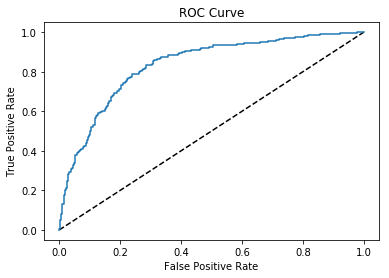

AUC Değeri :  0.8338411819021238

********************************************

Model icin veriler
Modelin doğruluk değeri :  0.7680412371134021
Hata Matrisi (Eğitim verileri)
------------------------------
[[285 101]
 [100 286]]
Hata Matrisi (Test verileri)
------------------------------
[[68 29]
 [16 81]]


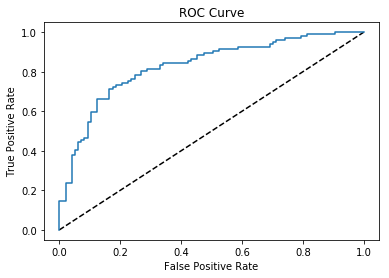

AUC Değeri :  0.8282495483048146

********************************************

Model icin veriler
Modelin doğruluk değeri :  0.7912280701754386
Hata Matrisi (Eğitim verileri)
------------------------------
[[1775  505]
 [ 493 1787]]
Hata Matrisi (Test verileri)
------------------------------
[[452 118]
 [120 450]]


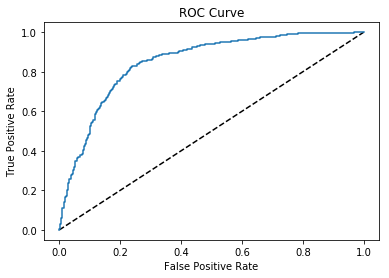

AUC Değeri :  0.8487349953831949

********************************************

Model icin veriler
Modelin doğruluk değeri :  0.7836663770634231
Hata Matrisi (Eğitim verileri)
------------------------------
[[1770  510]
 [ 561 1762]]
Hata Matrisi (Test verileri)
------------------------------
[[450 120]
 [129 452]]


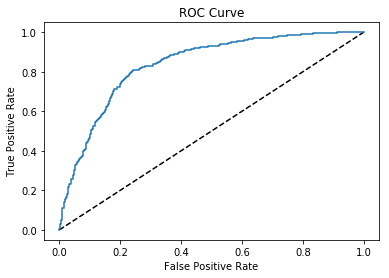

AUC Değeri :  0.8364223812543408

********************************************



In [122]:
X=[X_upsampled,X_downsampled,X_smote,X_adasyn]
y=[y_upsampled,y_downsampled,y_smote,y_adasyn]
for i in range(0,4): 
    print("Model icin veriler")
    model_result(X[i],y[i])
    print("\n********************************************\n")

Upsampled,Downsampled,Smote model, Adasyn model ile ilk modelimiz olmak üzere 5 adet modeli,  
1-Doğruluk Değeri  
2-AUC Değeri açısından karşılaştırısak;
  
Doğruluk Değerleri:  
**İlk Model=0.85 > Smote Model=0.79 > diğerleri=0.76**  
AUC Değerleri:  
**Smote Model=0.84 > Upsampled Model=0.83 > diğerleri=0.82** 

Test kümelerinin hata matrislerinin **True Pozitif**ve **True Negatif** toplamları açısından da bakalım. Doğru bir kıyaslama olabilmesi için gözlem sayıları aynı olan 3 metodu kıyasladık. Sıralama:  
**Smote model > Adasyn Model > Upsampled Model**  

Üç kıyaslama yönteminin ikisinde en önde bir diğerinde de ikinci sırada olan **Smote Model**'i en başarılı model seçebiliriz.

### MODEL OPTİMİZASYONU

Şimdi de Smote modelimizin stabil olup olmadığını ve optimum başarı için gereken hiperparametre değerlerini öğrenelim.Modelimizi tekrar kuralım.

In [123]:
X=df[['VMail Plan','Day Mins','Night Mins','Intl Mins','CustServ Calls',"Int'l Plan",'Eve Charge', 'Intl Calls']]
y=df["Churn"]
X = pd.get_dummies(data=X, drop_first=True)

smo = SMOTE(random_state=27, ratio=1.0)
X_smote, y_smote = smo.fit_sample(X, y)

X_eğitim, X_test, y_eğitim, y_test =  train_test_split(X, y, test_size=0.20, random_state=111, stratify = y)
logreg_model = LogisticRegression()
logreg_model.fit(X_eğitim, y_eğitim)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

10 kümeli çapraz doğrulama değerlerinin ortalamasını hem test hem eğitim kümesi için hesaplayalım.

In [124]:
ortalama_accuracy_test= model_selection.cross_val_score(log_reg, X_test, y_test,cv = 10).mean()
print("Test Doğruluk Ortalaması:", ortalama_accuracy_test)

ortalama_accuracy_test= model_selection.cross_val_score(log_reg, X_eğitim, y_eğitim,cv = 10).mean()
print("Eğitim Doğruluk Ortalaması:", ortalama_accuracy_test)

Test Doğruluk Ortalaması: 0.8607191316146541
Eğitim Doğruluk Ortalaması: 0.8608388949902848


Eğitim ve test arasında bir fark yok. Şimdi de C parametresinin farklı değerleri için kümelerimizin doğruluk değerlerine bakalım, en uygununu öğrenelim.

In [125]:
C_değerleri = [0.001,0.01,0.1,1,10,100, 1000]
dogruluk_df = pd.DataFrame(columns = ['C_Değeri','Doğruluk'])

dogruluk_değerleri = pd.DataFrame(columns=['C Değeri', 'Eğitim Doğruluğu', 'Test Doğruluğu'])

for c in C_değerleri:
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 111)
    lr.fit(X_eğitim,y_eğitim)
    dogruluk_değerleri = dogruluk_değerleri.append({'C Değeri': c,
                                                    'Eğitim Doğruluğu' : lr.score(X_eğitim, y_eğitim),
                                                    'Test Doğruluğu': lr.score(X_test, y_test)
                                                    }, ignore_index=True)
    
dogruluk_değerleri

,C Değeri,Eğitim Doğruluğu,Test Doğruluğu
0,0.001,0.855,0.855
1,0.010,0.856,0.850
2,0.100,0.861,0.853
3,1.000,0.862,0.859
4,10.000,0.861,0.861
5,100.000,0.862,0.859
6,1000.000,0.863,0.859


C=10 değeri için modelimizin başarısı optimum görünüyor. Modelimizi bir de C=10 ile tekrar kuruyoruz.

In [126]:
lr = LogisticRegression(penalty = 'l2', C = 10, random_state = 111)
lr.fit(X_eğitim,y_eğitim)

print('Eğitim Doğruluğu= ',lr.score(X_eğitim, y_eğitim))
print('Test Doğruluğu:',lr.score(X_test, y_test))

Eğitim Doğruluğu=  0.8612153038259565
Test Doğruluğu: 0.8605697151424287


### FARKLI MAKİNE ÖĞRENMESİ ALGORİTMALARI ile SINIFLANDIRMA

Bu bölümde farklı makine öğrenmesi algoritmalarını kullanarak daha iyi bir çözüm elde edip edemeyeceğimize bakacağız. Sırayla algoritmalar için en uygun parametreleri bulup, çalıştırarak doğruluk değerlerini elde edeceğiz.

#### a. K-Nearest Neighbors (K-En Yakın Komşuluk) 

In [127]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

GridsearchCV ile en verdiğimiz aralıklardaki en uygun parametreleri bulalım.

In [128]:
#nesneyi olstur.
knn=KNeighborsClassifier()

#parametre degerlerini ver.
k_range = list(range(1,51))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)

# fit grid
model = grid.fit(X,y)

# en iyi hali bul
print('En iyi tahmin ediciler:', model.best_estimator_)
print('En iyi Score:', model.best_score_)

En iyi tahmin ediciler: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')
En iyi Score: 0.876987698769877


Modelimizi en iyi parametrelerle kuralım ve tahminlerimizi yapalım.

In [129]:
#en son kıyas için doğruluk ve hassasiyet  ve auc değerleri icin liste olustur.
test_accuracy=[]
test_recall=[]
test_auc=[]
knn=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')
model=knn.fit(X_eğitim, y_eğitim)

# tahminleri yapıyoruz
y_preds = model.predict(X_test)

# dogruluk ve hassaiyet ve auc sonuclarını listeye ekliyoruz.
test_accuracy.append( accuracy_score(y_test, y_preds))
test_recall.append(recall_score(y_test, y_preds))
tahmin_test_ihtimal = model.predict_proba(X_test)[:,1]
test_auc.append(roc_auc_score(y_test, tahmin_test_ihtimal))
#dogruluk degerini yazdıralım.
print('Test Accuracy:', accuracy_score(y_test, y_preds))

Test Accuracy: 0.8770614692653673


#### b.Decision Tree(Karar Ağaçları) 

In [130]:
from sklearn.tree import DecisionTreeClassifier 

In [131]:
d_tree=DecisionTreeClassifier()

param_grid={'min_samples_split' : range(10,1000,50),'max_depth': range(1,20,2),'criterion':['entropy','gini']}

grid=GridSearchCV(d_tree,param_grid)

model = grid.fit(X,y)

In [132]:
# en iyi halini bul
print('En iyi tahmin ediciler:', model.best_estimator_)
print('En iyi Score:', model.best_score_)

En iyi tahmin ediciler: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
En iyi Score: 0.9396939693969397


In [133]:
dtc=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
model=dtc.fit(X_eğitim, y_eğitim)

# tahminleri yapalım.
y_preds = model.predict(X_test)

# sonucları ekle
test_accuracy.append( accuracy_score(y_test, y_preds))
test_recall.append(recall_score(y_test, y_preds))
tahmin_test_ihtimal = model.predict_proba(X_test)[:,1]
test_auc.append(roc_auc_score(y_test, tahmin_test_ihtimal))
#dogruluk yazdır.
print('Test Accuracy:', accuracy_score(y_test, y_preds))

Test Accuracy: 0.9505247376311844


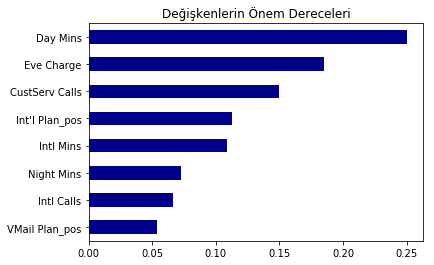

In [134]:
önem_dereceleri = pd.Series(data=model.feature_importances_,
                        index= X_eğitim.columns)

önem_dereceleri_sıralı = önem_dereceleri.sort_values()

önem_dereceleri_sıralı.plot(kind='barh', color='darkblue')
plt.title('Değişkenlerin Önem Dereceleri')
plt.show()

#### c. Random Forest (Rastgele Orman) 

In [135]:
from sklearn.ensemble import RandomForestClassifier

In [136]:
rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [10,20,30,40,50],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
model = grid.fit(X, y)

In [137]:
# en iyi halini bul
print('En iyi tahmin ediciler:',model.best_estimator_)
print('En iyi Score:',model.best_score_)

En iyi tahmin ediciler: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
En iyi Score: 0.9567956795679567


In [138]:
rf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model=rf.fit(X_eğitim, y_eğitim)

#tahminleri yapalım
y_preds = model.predict(X_test)

# sonucları ekle
test_accuracy.append( accuracy_score(y_test, y_preds))
test_recall.append(recall_score(y_test, y_preds))
tahmin_test_ihtimal = model.predict_proba(X_test)[:,1]
test_auc.append(roc_auc_score(y_test, tahmin_test_ihtimal))
#dogruluk yazdır.
print('Test Accuracy:', accuracy_score(y_test, y_preds))

Test Accuracy: 0.9565217391304348


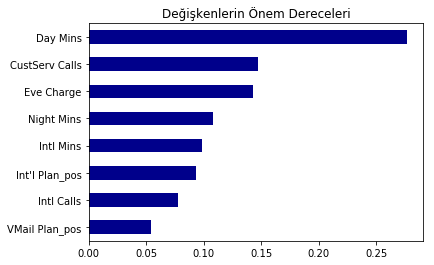

In [139]:
önem_dereceleri = pd.Series(data=model.feature_importances_,
                        index= X_eğitim.columns)

önem_dereceleri_sıralı = önem_dereceleri.sort_values()

önem_dereceleri_sıralı.plot(kind='barh', color='darkblue')
plt.title('Değişkenlerin Önem Dereceleri')
plt.show()

#### d. AdaBoost Karar ağaçları

In [140]:
from sklearn.ensemble import AdaBoostClassifier

In [141]:
ada_dt = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)

scores = cross_val_score(ada_dt, X, y, cv=10)

print('CV Score Ortalaması:',scores.mean())

CV Score Ortalaması: 0.9249950549351749


In [142]:
model = ada_dt.fit(X_eğitim, y_eğitim)

# tahminleri yapalım
y_preds = model.predict(X_test)

# sonucları ekle
test_accuracy.append( accuracy_score(y_test, y_preds))
test_recall.append(recall_score(y_test, y_preds))
tahmin_test_ihtimal = model.predict_proba(X_test)[:,1]
test_auc.append(roc_auc_score(y_test, tahmin_test_ihtimal))
#dogruluk yazdır.
print('Test Accuracy:', accuracy_score(y_test, y_preds))

Test Accuracy: 0.9145427286356822


#### e. Gradient Boosting 

In [143]:
from sklearn.ensemble import GradientBoostingClassifier

In [144]:
grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1)

scores = cross_val_score(grad_boost, X, y, cv=10)

print('CV Score Ortalaması:',scores.mean())

CV Score Ortalaması: 0.9273938609267951


In [145]:
model = grad_boost.fit(X_eğitim, y_eğitim)

# tahminleri yapalım
y_preds = model.predict(X_test)

# sonucları ekle
test_accuracy.append( accuracy_score(y_test, y_preds))
test_recall.append(recall_score(y_test, y_preds))
tahmin_test_ihtimal = model.predict_proba(X_test)[:,1]
test_auc.append(roc_auc_score(y_test, tahmin_test_ihtimal))
#dogruluk yazdır.
print('Test Accuracy:', accuracy_score(y_test, y_preds))

Test Accuracy: 0.9295352323838081


#### f. Light GBM

In [146]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [147]:
lgb = LGBMClassifier(max_depth=8,
                        num_leaves=40,
                        learning_rate=0.4)

scores= cross_val_score(lgb, X,y,cv=10)
print('CV Score Ortalaması:', scores.mean())



CV Score Ortalaması: 0.957700814587042


In [148]:
model = lgb.fit(X_eğitim, y_eğitim)

# tahminleri yapalım
y_preds = model.predict(X_test)

# sonucları ekle
test_accuracy.append( accuracy_score(y_test, y_preds))
test_recall.append(recall_score(y_test, y_preds))
tahmin_test_ihtimal = model.predict_proba(X_test)[:,1]
test_auc.append(roc_auc_score(y_test, tahmin_test_ihtimal))
#dogruluk yazdır.
print('Test Accuracy:', accuracy_score(y_test, y_preds))

Test Accuracy: 0.9565217391304348


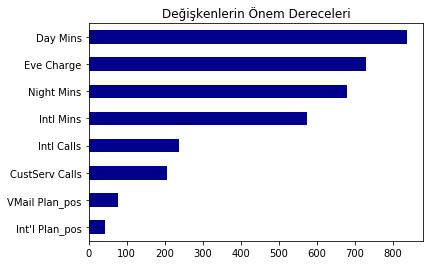

In [149]:
önem_dereceleri = pd.Series(data=model.feature_importances_,
                        index= X_eğitim.columns)

önem_dereceleri_sıralı = önem_dereceleri.sort_values()

önem_dereceleri_sıralı.plot(kind='barh', color='darkblue')
plt.title('Değişkenlerin Önem Dereceleri')
plt.show()

#### g. XGBoost

In [150]:
import xgboost as xgb
from xgboost import XGBClassifier

In [151]:
xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=9, 
                      gamma=0.1)


scores= cross_val_score(xgb, X,y,cv=10)
print('CV Score Ortalaması:', scores.mean())



CV Score Ortalaması: 0.9450998903094711


In [152]:
model = xgb.fit(X_eğitim, y_eğitim)

# tahminleri yapalım
y_preds = model.predict(X_test)

# sonucları ekle
test_accuracy.append( accuracy_score(y_test, y_preds))
test_recall.append(recall_score(y_test, y_preds))
tahmin_test_ihtimal = model.predict_proba(X_test)[:,1]
test_auc.append(roc_auc_score(y_test, tahmin_test_ihtimal))
#dogruluk yazdır.
print('Test Accuracy:', accuracy_score(y_test, y_preds))

Test Accuracy: 0.9460269865067467


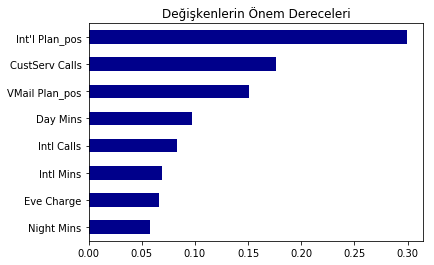

In [153]:
önem_dereceleri = pd.Series(data=model.feature_importances_,
                        index= X_eğitim.columns)

önem_dereceleri_sıralı = önem_dereceleri.sort_values()

önem_dereceleri_sıralı.plot(kind='barh', color='darkblue')
plt.title('Değişkenlerin Önem Dereceleri')
plt.show()

#### h. Karşılaştırma

Bu bölümde 7 farklı makine öğrenmesi yöntemiyle sınflandırma yaptık. Şimdi hepsini Accuracy(Doğruluk) ve AUC(Eğri Altında Kalan Alan) açısından karşılastıralım.

In [154]:
Models=['K-Nearest Neighbor','Decision Tree','Random Forest','Adaboost','Gradient Boost','Light GBM','XGBoost']
                                   

In [164]:
for i in range(0,7):
    print(Models[i],' için dogruluk degeri=',test_accuracy[i],'AUC değeri:',test_auc[i])

K-Nearest Neighbor  için dogruluk degeri= 0.8770614692653673 AUC değeri: 0.6736389943931995
Decision Tree  için dogruluk degeri= 0.9505247376311844 AUC değeri: 0.8778260083197684
Random Forest  için dogruluk degeri= 0.9565217391304348 AUC değeri: 0.9350515463917526
Adaboost  için dogruluk degeri= 0.9145427286356822 AUC değeri: 0.8430638451799602
Gradient Boost  için dogruluk degeri= 0.9295352323838081 AUC değeri: 0.8666666666666667
Light GBM  için dogruluk degeri= 0.9565217391304348 AUC değeri: 0.9276722734671732
XGBoost  için dogruluk degeri= 0.9460269865067467 AUC değeri: 0.9073250135648399


Yukardaki 7 farklı makine öğrenmesi yöntemini karşılaştırdığımızda en yüksek doğruluk ve hassasiyet değerlerinin **Light GBM**  ile elde edildiğini görüyoruz. Daha sonra bu değere çok yakın sonuçları **Random Forest** algoritmasında görüyoruz. Başarı ölçütümüz AUC olduğunda ise yine bu iki algoritma bu sefer **Random Forest** önde olmak üzere en iyi ilk ikide yer alıyor. 

### SONUÇ

Oluşturduğumuz 5 farklı logistic regresyon modelinden, farklı başarı ölçütlerine göre en başarılısı Smote Algoritması ile kümemizde eleman sayısı dengelemesi yapan modelimiz oldu. Bu modelimiz %86 doğruluk oranında çalışıyor. Yani elimizdeki model ile müşterilerimizin 'Churn' durumlarını **%86** isabetlilikle tahmin edebiliyoruz demektir. Ayrılmayı düşündüğünü tespit ettiğimiz müşteriler için buna nelerin sebep olduğunu anlayabilmek bu durumu önleyebilmek için gerekli. Modelimiz aracılığıyla bu kararda nelerin önemli olduğunu belli ölçüde anlayabilmiş olduk.  
Daha sonra farklı makine öğrenmesi yöntemlerini denedik ve doğruluk başarımızı **%95** seviyesine çıkardık.